
=== BASELINE (2025-level inputs) ===
Baseline expected wins: 44.97

=== Δ WINS SUMMARY (Monte Carlo) ===
Brooks: {'mean': 4.742901538751695, 'p10': 3.8865724294887385, 'p50': 4.750422654247803, 'p90': 5.591435129319459}
Wiles : {'mean': 2.6242239498169457, 'p10': 1.8380726923019033, 'p50': 2.633356905817106, 'p90': 3.3962502661648766}
Both  : {'mean': 7.496574847091568, 'p10': 6.282680689149711, 'p50': 7.490665303823189, 'p90': 8.686730906653425}

=== EXPECTED WINS BY SCENARIO ===
Baseline: 44.97
+Brooks : 49.72 (Δ 4.74)
+Wiles  : 47.60 (Δ 2.62)
+Both   : 52.47 (Δ 7.50)


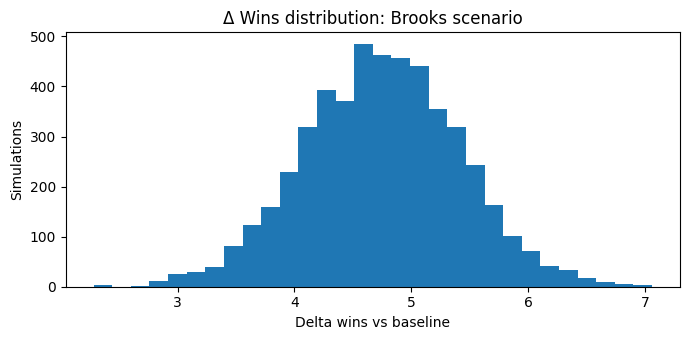

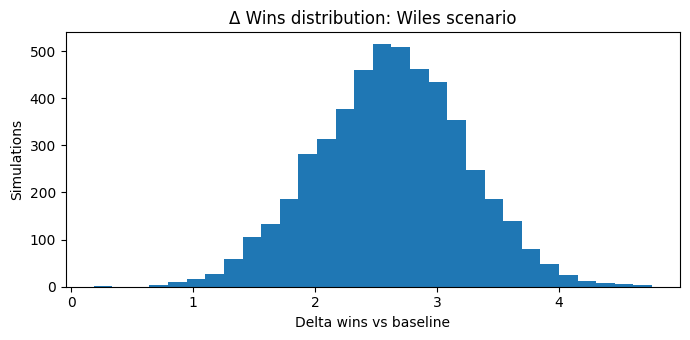

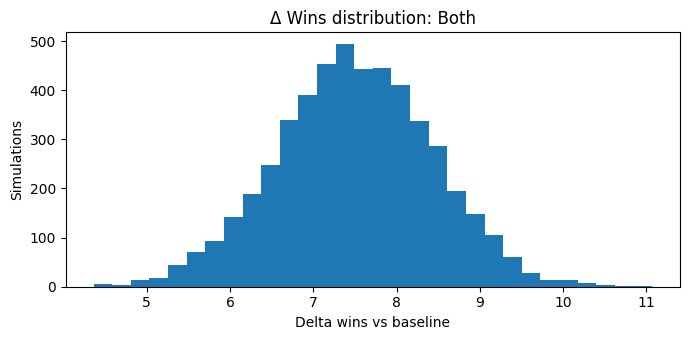

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# =========================
# 0) Load your datasets
# =========================
kbo_bat = pd.read_csv("KBO_batting_2021_2025_merged.csv")
kbo_pit = pd.read_csv("KBO_pitching_2021_2025_merged.csv")
kbo_fld = pd.read_csv("KBO_fielding_2021_2025_merged.csv")
kw_bat  = pd.read_csv("kiwoom_batting_2021_2025_merged (1).csv")
kw_pit  = pd.read_csv("kiwoom_pitching_2021_2025_merged (1).csv")

for df in [kbo_bat, kbo_pit, kbo_fld, kw_bat, kw_pit]:
    df.columns = df.columns.str.strip()
    if "season" in df.columns:
        df["season"] = pd.to_numeric(df["season"], errors="coerce").astype("Int64")

def to_num(df, cols):
    out = df.copy()
    for c in cols:
        if c in out.columns:
            s = out[c].astype(str).str.strip()
            s = s.replace({"": None, "nan": None, "None": None, "-": None, "—": None})
            s = s.str.replace(",", "", regex=False).str.replace("%", "", regex=False)
            s = s.str.replace(r"[^0-9\.\-]", "", regex=True)
            out[c] = pd.to_numeric(s, errors="coerce")
    return out

def guess_kiwoom_label(df):
    labels = df["Tm"].dropna().unique().tolist()
    for x in labels:
        xl = str(x).lower()
        if ("키움" in str(x)) or ("kiwoom" in xl):
            return x
    raise ValueError("Could not find Kiwoom label in team tables.")

TEAM = guess_kiwoom_label(kbo_bat)
SEASON = 2025
GAMES = 144
GAMMA = 1.83

def pythag_wins(rs, ra, games=GAMES, gamma=GAMMA):
    wpct = (rs**gamma) / (rs**gamma + ra**gamma)
    return wpct * games

# =========================
# 1) Fit league calibration models (from your KBO team tables)
# =========================
kbo_bat2 = to_num(kbo_bat, ["R/G","OBP","SLG","OPS","PA"])
bat_train = kbo_bat2.dropna(subset=["R/G","OBP","SLG"])
bat_model = LinearRegression().fit(bat_train[["OBP","SLG"]].values, bat_train["R/G"].values)

kbo_pit2 = to_num(kbo_pit, ["RA9","ERA","WHIP"])
kbo_fld2 = to_num(kbo_fld, ["Fld%","E","G"])
pf = kbo_pit2.merge(
    kbo_fld2[["season","Tm","Fld%","E","G"]].rename(columns={"G":"G_fld"}),
    on=["season","Tm"], how="left"
)
pf["E_per_G"] = pf["E"] / pf["G_fld"]
train_pf = pf.dropna(subset=["RA9","ERA","Fld%","E_per_G"])
pit_model = LinearRegression().fit(train_pf[["ERA","Fld%","E_per_G"]].values, train_pf["RA9"].values)

# =========================
# 2) Baseline Kiwoom 2025 (team context)
# =========================
team_bat = kbo_bat2[(kbo_bat2["season"]==SEASON) & (kbo_bat2["Tm"]==TEAM)].iloc[0]
team_pit = kbo_pit2[(kbo_pit2["season"]==SEASON) & (kbo_pit2["Tm"]==TEAM)].iloc[0]
team_fld = kbo_fld2[(kbo_fld2["season"]==SEASON) & (kbo_fld2["Tm"]==TEAM)].iloc[0]

baseline_rg  = bat_model.predict(np.array([[team_bat["OBP"], team_bat["SLG"]]]))[0]
baseline_ra9 = pit_model.predict(np.array([[team_pit["ERA"], team_fld["Fld%"], team_fld["E"]/team_fld["G"]]]))[0]
baseline_rs  = baseline_rg * GAMES
baseline_ra  = baseline_ra9 * GAMES
baseline_wins = pythag_wins(baseline_rs, baseline_ra)

# =========================
# 3) Helper functions for roster swap calculations
# =========================
kw_bat_num = kw_bat.copy()
kw_pit_num = kw_pit.copy()

for c in ["PA","AB","H","BB","HBP","SF","SH","TB","OBP","SLG","OPS"]:
    kw_bat_num[c] = pd.to_numeric(kw_bat_num[c], errors="coerce")
for c in ["IP","ER","H","BB","HR","ERA","GS"]:
    kw_pit_num[c] = pd.to_numeric(kw_pit_num[c], errors="coerce")

kw25_bat = kw_bat_num[kw_bat_num["season"]==SEASON].copy()
kw25_pit = kw_pit_num[kw_pit_num["season"]==SEASON].copy()

team_tot = kw25_bat[["PA","AB","H","BB","HBP","SF","SH","TB"]].sum(numeric_only=True).astype(float)

bb_rate  = team_tot["BB"]/team_tot["PA"]
hbp_rate = team_tot["HBP"]/team_tot["PA"]
sf_rate  = team_tot["SF"]/team_tot["PA"]
sh_rate  = team_tot["SH"]/team_tot["PA"]

def compute_team_obp_slg(tot):
    AB, H, BB, HBP, SF, TB = tot["AB"], tot["H"], tot["BB"], tot["HBP"], tot["SF"], tot["TB"]
    obp = (H+BB+HBP) / (AB+BB+HBP+SF)
    slg = TB / AB
    return obp, slg

def remove_pa_portion(df_sorted, pa_remove):
    removed = {"PA":0.0,"AB":0.0,"H":0.0,"BB":0.0,"HBP":0.0,"SF":0.0,"SH":0.0,"TB":0.0}
    remaining = pa_remove
    for _, r in df_sorted.iterrows():
        pa = float(r["PA"])
        if pa <= 0:
            continue
        take = min(pa, remaining)
        frac = take/pa
        for k in removed.keys():
            removed[k] += float(r[k]) * frac
        remaining -= take
        if remaining <= 1e-9:
            break
    return removed

def brooks_components(pa, obp, slg):
    BB  = int(round(pa * bb_rate))
    HBP = int(round(pa * hbp_rate))
    SF  = int(round(pa * sf_rate))
    SH  = int(round(pa * sh_rate))
    AB = pa - BB - HBP - SF - SH
    AB = max(1, AB)
    denom = AB + BB + HBP + SF
    H = obp * denom - BB - HBP
    H = int(round(H))
    H = max(0, min(AB, H))
    TB = int(round(slg * AB))
    TB = max(H, TB)
    return {"PA":pa, "AB":AB, "H":H, "BB":BB, "HBP":HBP, "SF":SF, "SH":SH, "TB":TB}

def remove_ip_portion(rows_df, ip_remove):
    removed = {"IP":0.0,"ER":0.0,"H":0.0,"BB":0.0,"HR":0.0}
    remaining = ip_remove
    for _, r in rows_df.iterrows():
        ip = float(r["IP"])
        if ip <= 0:
            continue
        take = min(ip, remaining)
        frac = take / ip
        removed["IP"] += take
        removed["ER"] += float(r["ER"]) * frac
        removed["H"]  += float(r["H"]) * frac
        removed["BB"] += float(r["BB"]) * frac
        removed["HR"] += float(r["HR"]) * frac
        remaining -= take
        if remaining <= 1e-9:
            break
    return removed

pit_tot = kw25_pit[["IP","ER","H","BB","HR"]].sum(numeric_only=True).astype(float)

# =========================
# 4) Simulation settings for imports (conservative)
# =========================
BROOKS_PA = 520
BROOKS_OBP_MEAN, BROOKS_SLG_MEAN = 0.335, 0.470
WILES_IP = 160.0
WILES_ERA_MEAN = 4.05

def clip(a, lo, hi):
    return np.minimum(np.maximum(a, lo), hi)

# Brooks replaces worst 520 PA hitters (OPS ascending, PA>=50)
sorted_hitters = kw25_bat[kw25_bat["PA"]>=50].sort_values("OPS", ascending=True)
removed_520 = remove_pa_portion(sorted_hitters, 520.0)

# Wiles replaces worst 160 IP starter innings (ERA descending, GS>=5, IP>=20)
sorted_sp = kw25_pit[(kw25_pit["GS"]>=5) & (kw25_pit["IP"]>=20)].sort_values("ERA", ascending=False)
removed_160 = remove_ip_portion(sorted_sp, 160.0)

# =========================
# 5) Monte Carlo season simulation (Δ wins)
# =========================
rng = np.random.default_rng(42)
N = 5000

brooks_obp_s = clip(rng.normal(BROOKS_OBP_MEAN, 0.020, N), 0.280, 0.420)
brooks_slg_s = clip(rng.normal(BROOKS_SLG_MEAN, 0.030, N), 0.360, 0.620)
wiles_era_s  = clip(rng.normal(WILES_ERA_MEAN, 0.45,  N), 2.50,  6.80)

fld_fld = float(team_fld["Fld%"])
fld_eperg = float(team_fld["E"]/team_fld["G"])

delta_brooks = np.empty(N)
delta_wiles  = np.empty(N)
delta_both   = np.empty(N)

for i in range(N):
    # Brooks scenario => new OBP/SLG => new R/G
    bc = brooks_components(BROOKS_PA, brooks_obp_s[i], brooks_slg_s[i])
    bat_tot_i = {k: float(team_tot[k]) - removed_520[k] + bc[k] for k in removed_520.keys()}
    obp_i, slg_i = compute_team_obp_slg(bat_tot_i)
    rg_i = bat_model.predict(np.array([[obp_i, slg_i]]))[0]
    rs_i = rg_i * GAMES
    wins_b = pythag_wins(rs_i, baseline_ra)
    delta_brooks[i] = wins_b - baseline_wins

    # Wiles scenario => new team ERA => new RA9
    w_er = wiles_era_s[i] * WILES_IP / 9.0
    new_ER = float(pit_tot["ER"]) - removed_160["ER"] + w_er
    new_IP = float(pit_tot["IP"]) - removed_160["IP"] + WILES_IP
    team_era_i = new_ER * 9.0 / new_IP
    ra9_i = pit_model.predict(np.array([[team_era_i, fld_fld, fld_eperg]]))[0]
    ra_i  = ra9_i * GAMES
    wins_w = pythag_wins(baseline_rs, ra_i)
    delta_wiles[i] = wins_w - baseline_wins

    # Both
    wins_bw = pythag_wins(rs_i, ra_i)
    delta_both[i] = wins_bw - baseline_wins

def summarize(arr):
    return {
        "mean": float(np.mean(arr)),
        "p10": float(np.quantile(arr, 0.10)),
        "p50": float(np.quantile(arr, 0.50)),
        "p90": float(np.quantile(arr, 0.90)),
    }

summ_b  = summarize(delta_brooks)
summ_w  = summarize(delta_wiles)
summ_bw = summarize(delta_both)

print("\n=== BASELINE (2025-level inputs) ===")
print(f"Baseline expected wins: {baseline_wins:.2f}")

print("\n=== Δ WINS SUMMARY (Monte Carlo) ===")
print("Brooks:", summ_b)
print("Wiles :", summ_w)
print("Both  :", summ_bw)

print("\n=== EXPECTED WINS BY SCENARIO ===")
print(f"Baseline: {baseline_wins:.2f}")
print(f"+Brooks : {baseline_wins + summ_b['mean']:.2f} (Δ {summ_b['mean']:.2f})")
print(f"+Wiles  : {baseline_wins + summ_w['mean']:.2f} (Δ {summ_w['mean']:.2f})")
print(f"+Both   : {baseline_wins + summ_bw['mean']:.2f} (Δ {summ_bw['mean']:.2f})")

# Optional: histograms
plt.figure(figsize=(7,3.5))
plt.hist(delta_brooks, bins=30)
plt.title("Δ Wins distribution: Brooks scenario")
plt.xlabel("Delta wins vs baseline"); plt.ylabel("Simulations")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.5))
plt.hist(delta_wiles, bins=30)
plt.title("Δ Wins distribution: Wiles scenario")
plt.xlabel("Delta wins vs baseline"); plt.ylabel("Simulations")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.5))
plt.hist(delta_both, bins=30)
plt.title("Δ Wins distribution: Both")
plt.xlabel("Delta wins vs baseline"); plt.ylabel("Simulations")
plt.tight_layout(); plt.show()
